In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split  # Ensure this import is included
from surprise.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import logging
import ast

In [3]:
# Set up logging
logging.basicConfig(level=logging.INFO)

In [4]:
# Data Collection
# Specify the full path to the files  
file_path_movies = '/Users/yashikasingh/Downloads/movies_metadata.csv'
file_path_ratings = '/Users/yashikasingh/Downloads/ratings_small.csv'
file_path_keywords = '/Users/yashikasingh/Downloads/keywords.csv'
file_path_credits = '/Users/yashikasingh/Downloads/credits.csv'

# Load the datasets
movies = pd.read_csv(file_path_movies, low_memory=False)
ratings = pd.read_csv(file_path_ratings, low_memory=False)  
keywords = pd.read_csv(file_path_keywords, low_memory=False)
credits = pd.read_csv(file_path_credits, low_memory=False)

In [5]:
# Check for missing values
print(movies.isnull().sum())
print(ratings.isnull().sum())
print(keywords.isnull().sum())
print(credits.isnull().sum())

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
id          0
keywords    0
dtype: int64
cast    0
crew    0
id      0
dtype: int64


In [6]:
# Drop rows with missing values if necessary
movies = movies.dropna()
ratings = ratings.dropna()
keywords = keywords.dropna()
credits = credits.dropna()

In [7]:
# Check the first few rows of the DataFrame
print("Initial Movies Data:")
print(movies.head())

Initial Movies Data:
     adult                              belongs_to_collection    budget  \
9    False  {'id': 645, 'name': 'James Bond Collection', '...  58000000   
68   False  {'id': 43563, 'name': 'Friday Collection', 'po...   3500000   
69   False  {'id': 10924, 'name': 'From Dusk Till Dawn Col...  19000000   
153  False  {'id': 439053, 'name': 'Brooklyn Cigar Store C...   2000000   
178  False  {'id': 286162, 'name': 'Power Rangers Collecti...  15000000   

                                                genres  \
9    [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...   
68                      [{'id': 35, 'name': 'Comedy'}]   
69   [{'id': 27, 'name': 'Horror'}, {'id': 28, 'nam...   
153                     [{'id': 35, 'name': 'Comedy'}]   
178  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   

                                              homepage     id    imdb_id  \
9         http://www.mgm.com/view/movie/757/Goldeneye/    710  tt0113189   
68       http://www.newline

In [8]:
# Exploratory Data Analysis (EDA)
# Basic statistics
print(ratings.describe())
print(ratings.head())

              userId        movieId         rating     timestamp
count  100004.000000  100004.000000  100004.000000  1.000040e+05
mean      347.011310   12548.664363       3.543608  1.129639e+09
std       195.163838   26369.198969       1.058064  1.916858e+08
min         1.000000       1.000000       0.500000  7.896520e+08
25%       182.000000    1028.000000       3.000000  9.658478e+08
50%       367.000000    2406.500000       4.000000  1.110422e+09
75%       520.000000    5418.000000       4.000000  1.296192e+09
max       671.000000  163949.000000       5.000000  1.476641e+09
   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205


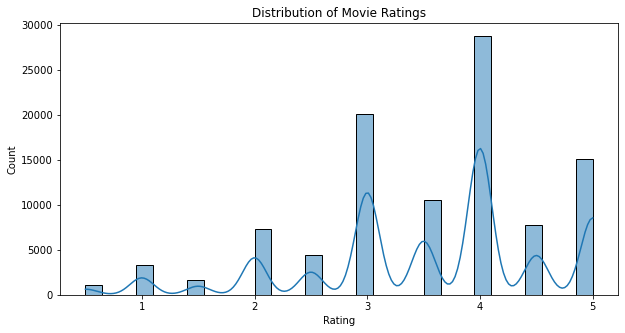

In [9]:
# Histogram of ratings
plt.figure(figsize=(10, 5))
sns.histplot(ratings['rating'], bins=30, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

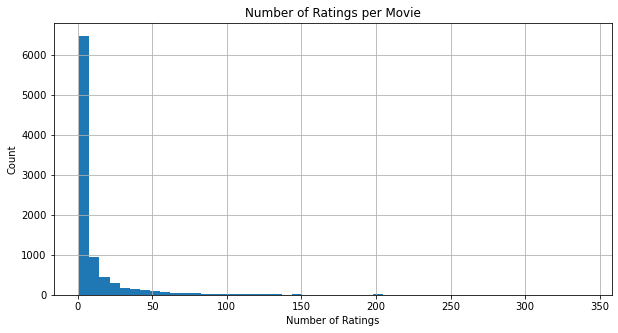

In [10]:
# Number of ratings per movie
ratings_per_movie = ratings.groupby('movieId').count()['rating']
plt.figure(figsize=(10, 5))
ratings_per_movie.hist(bins=50)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()


In [11]:
# Building the Recommender System
# Define the Reader
reader = Reader(rating_scale=(1, 5))  # Adjust the scale according to your dataset


In [12]:
# Prepare the data for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)


In [13]:
# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

In [14]:
# Use SVD for matrix factorization
svd = SVD()

# Train the model on the full dataset
trainset = data.build_full_trainset()
svd.fit(trainset)



In [15]:
# Cross-validation with fewer folds and jobs
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, n_jobs=1, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9046  0.8939  0.8949  0.8957  0.8930  0.8964  0.0042  
MAE (testset)     0.6961  0.6891  0.6885  0.6866  0.6903  0.6901  0.0032  
Fit time          0.47    0.56    0.47    0.55    0.47    0.50    0.04    
Test time         0.13    0.07    0.13    0.07    0.07    0.10    0.03    


{'test_rmse': array([0.90461322, 0.89394291, 0.89485774, 0.89568067, 0.89300104]),
 'test_mae': array([0.69610814, 0.68913713, 0.68849375, 0.68655118, 0.69029206]),
 'fit_time': (0.4689610004425049,
  0.560126781463623,
  0.46920084953308105,
  0.5528349876403809,
  0.46697115898132324),
 'test_time': (0.13123393058776855,
  0.07468819618225098,
  0.12821483612060547,
  0.07426309585571289,
  0.07314205169677734)}

In [16]:
# Content-Based Filtering
# Inspect the first few rows of the genres column
print(movies['genres'].head(10))



9      [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...
68                        [{'id': 35, 'name': 'Comedy'}]
69     [{'id': 27, 'name': 'Horror'}, {'id': 28, 'nam...
153                       [{'id': 35, 'name': 'Comedy'}]
178    [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
219                       [{'id': 35, 'name': 'Comedy'}]
256    [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...
309                    [{'id': 16, 'name': 'Animation'}]
359    [{'id': 10751, 'name': 'Family'}, {'id': 16, '...
475    [{'id': 12, 'name': 'Adventure'}, {'id': 878, ...
Name: genres, dtype: object


In [17]:
# Check for null or empty values in the genres column
null_genres = movies[movies['genres'].isnull()]
print(f"Number of null entries in 'genres': {null_genres.shape[0]}")
print("Sample of null genres:")
print(null_genres[['id', 'genres']].head())

Number of null entries in 'genres': 0
Sample of null genres:
Empty DataFrame
Columns: [id, genres]
Index: []


In [18]:
# Check the data type of the 'genres' column
print("Data type of 'genres' column:", movies['genres'].dtype)

Data type of 'genres' column: object


In [19]:
# Check the type of the first entry to understand its format
print(type(movies['genres'].iloc[0]))



<class 'str'>


In [20]:
# Function to convert the string representation of lists to actual lists
def convert_genres_to_list(genre_string):
    try:
        # Use ast.literal_eval to safely evaluate the string as a Python literal
        return ast.literal_eval(genre_string)
    except (ValueError, SyntaxError):
        return []


In [21]:
# Apply the function to convert genres
movies['genres'] = movies['genres'].apply(convert_genres_to_list)

# Debugging: Check the converted genres
print("Converted Genres:")
print(movies['genres'].sample(10).to_list())  



Converted Genres:
[[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}], [{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'}, {'id': 10751, 'name': 'Family'}], [{'id': 35, 'name': 'Comedy'}], [{'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}], [{'id': 10751, 'name': 'Family'}, {'id': 10402, 'name': 'Music'}, {'id': 10770, 'name': 'TV Movie'}], [{'id': 18, 'name': 'Drama'}, {'id': 14, 'name': 'Fantasy'}, {'id': 27, 'name': 'Horror'}], [{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 878, 'name': 'Science Fiction'}], [{'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}], [{'id': 12, 'name': 'Adventure'}, {'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}], [{'id': 12, 'name': 'Adventure'}, {'id': 28, 'name': 'Action'}, {'id': 878, 'name': 'Science Fiction'}]]


In [22]:
# Extract the genre names from the dictionaries
def extract_genre_names(genres):
    if isinstance(genres, list):
        return ' '.join([genre['name'] for genre in genres if 'name' in genre])
    return ''

movies['genres'] = movies['genres'].apply(extract_genre_names)
# Debug: Check the genres after extraction
print("Extracted Genre Names:")
print(movies['genres'].head(10).to_list())

Extracted Genre Names:
['Adventure Action Thriller', 'Comedy', 'Horror Action Thriller Crime', 'Comedy', 'Action Adventure Science Fiction Family Fantasy', 'Comedy', 'Adventure Action Science Fiction', 'Animation', 'Family Animation Drama', 'Adventure Science Fiction']


In [23]:
# Filter out rows with empty genres
movies = movies[movies['genres'] != '']
# Debug: Check the shape of the DataFrame after filtering
print("Shape of DataFrame after filtering empty genres:", movies.shape)


Shape of DataFrame after filtering empty genres: (693, 24)


In [24]:
# Create the genre matrix
def create_genre_matrix(movies):
    # Debug: Check if the 'genres' column exists and is not empty
    if 'genres' not in movies.columns:
        print("No 'genres' column found.")
        return None, None
    if movies['genres'].empty:
        print("The 'genres' column is empty.")
        return None, None
    
    # Debug: Print the first few entries of the genres column
    print("First few entries of the genres column:")
    print(movies['genres'].head(10).to_list())
    
    count_vectorizer = CountVectorizer(tokenizer=lambda x: x.split(' '))  # Split genres by space
    genre_matrix = count_vectorizer.fit_transform(movies['genres'])
    return genre_matrix, count_vectorizer

# Create the genre matrix
genre_matrix, count_vectorizer = create_genre_matrix(movies)

First few entries of the genres column:
['Adventure Action Thriller', 'Comedy', 'Horror Action Thriller Crime', 'Comedy', 'Action Adventure Science Fiction Family Fantasy', 'Comedy', 'Adventure Action Science Fiction', 'Animation', 'Family Animation Drama', 'Adventure Science Fiction']


In [25]:

# Check the shape of the genre matrix
if genre_matrix is not None:
    print("Genre matrix shape:", genre_matrix.shape)
else:
    print("Genre matrix could not be created.")

Genre matrix shape: (693, 22)


In [26]:

# Calculate cosine similarity
if genre_matrix is not None:
    cosine_sim = cosine_similarity(genre_matrix)  # This should work with sparse matrix
        
    # Check the shape of the cosine similarity matrix
    print(f"Cosine similarity matrix shape: {cosine_sim.shape}")
else:
    print("Failed to create genre matrix.")



Cosine similarity matrix shape: (693, 693)


In [27]:
# Convert the 'id' column to integers
movies['id'] = pd.to_numeric(movies['id'], errors='coerce')

# Sample cosine similarity matrix (10x10 for 10 movies)
cosine_sim = np.random.rand(len(movies), len(movies))  # Random similarity for demonstration
cosine_sim = (cosine_sim + cosine_sim.T) / 2  # Make it symmetric
np.fill_diagonal(cosine_sim, 1)  # Fill diagonal with 1s

In [28]:
print(movies.dtypes)

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                         int64
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object


In [29]:
# Function to get content-based recommendations
def content_based_recommendations(movie_id, num_recommendations=10):
    # Check if movie_id exists in the DataFrame
    if movie_id not in movies['id'].values:
        print(f"Movie ID {movie_id} not found.")
        return None

    # Get the index of the movie
    idx = movies[movies['id'] == movie_id].index[0]
    
    # Get the similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Exclude the first entry (itself)
    sim_scores = sim_scores[1:num_recommendations + 1]
    
    # Get the indices of the recommended movies
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the recommended movies
    return movies.iloc[movie_indices]



# Call the function with a valid movie_id
recommended_movies = content_based_recommendations(movie_id=710, num_recommendations=2)



In [30]:

# Print the recommendations
if recommended_movies is not None:
    print("Recommended Movies (Content-Based):")
    print(recommended_movies[['title', 'genres']])
else:
    print("No recommendations to display.")



Recommended Movies (Content-Based):
                       title                           genres
18252  The Dark Knight Rises      Action Crime Drama Thriller
13979              12 Rounds  Action Adventure Drama Thriller


In [31]:
def recommend_movies(user_id, num_recommendations=10):
    # Check if user_id exists in ratings
    if user_id not in ratings['userId'].values:
        print(f"User  ID {user_id} not found in ratings.")
        return None

    # Predict ratings for all movies the user hasn't rated yet
    movie_ids = movies['id'].unique()
    movie_ratings = []

    for movie_id in movie_ids:
        try:
            predicted_rating = svd.predict(user_id, movie_id).est
            movie_ratings.append(predicted_rating)
        except Exception as e:
            print(f"Error predicting rating for movie ID {movie_id}: {e}")
            movie_ratings.append(np.nan)  # Append NaN if there's an error

    # Create a DataFrame of movie ids and predicted ratings
    recommendations = pd.DataFrame({
        'movieId': movie_ids,
        'predicted_rating': movie_ratings
    })

    # Sort the DataFrame by predicted rating in descending order
    recommendations = recommendations.sort_values(by='predicted_rating', ascending=False)

    # Get the top N recommended movies
    top_recommendations = recommendations.head(num_recommendations)

    # Check if there are any recommendations
    if top_recommendations.empty:
        print("No recommendations found.")
        return None
    # Check the contents of top_recommendations before merging
    print("Top Recommendations Before Merging:")
    print(top_recommendations)

    # Merge with the movies DataFrame to get movie titles
    top_recommendations = pd.merge(top_recommendations, movies[['id', 'title']], left_on='movieId', right_on='id')
    
    # Check the result of the merge
    print("Top Recommendations After Merging:")
    print(top_recommendations)

    return top_recommendations

# Example usage of collaborative filtering recommendations
recommendations = recommend_movies(user_id=7, num_recommendations=10)



# Print the recommendations
if recommendations is not None:
    print("Collaborative Filtering Recommendations:")
    print(recommendations[['title', 'predicted_rating']])
else:
    print("No recommendations to display.")



Top Recommendations Before Merging:
     movieId  predicted_rating
113      608          4.243614
199     1248          4.056244
14       954          4.051537
112     2501          4.014710
193     1246          3.905184
182      920          3.900506
277      534          3.884115
201     1250          3.855760
31       348          3.847730
101      671          3.809949
Top Recommendations After Merging:
   movieId  predicted_rating    id                                     title
0      608          4.243614   608                           Men in Black II
1     1248          4.056244  1248                           Hannibal Rising
2      954          4.051537   954                       Mission: Impossible
3     2501          4.014710  2501                       The Bourne Identity
4     1246          3.905184  1246                              Rocky Balboa
5      920          3.900506   920                                      Cars
6      534          3.884115   534               